In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline 

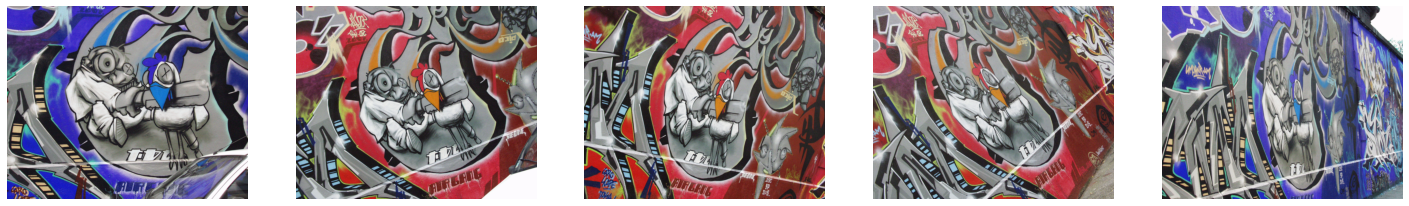

In [235]:
# --------------------- opening images (img1 to 5) ---------------------- 
img1 = cv.imread("graf/img1.ppm"); assert img1 is not None; img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB) 
img2 = cv.imread("graf/img2.ppm"); assert img2 is not None
img3 = cv.imread("graf/img3.ppm"); assert img3 is not None
img4 = cv.imread("graf/img4.ppm"); assert img4 is not None
img5 = cv.imread("graf/img5.ppm"); assert img5 is not None; img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB) 

fig, ax = plt.subplots(1, 5, figsize = (25, 5)) 
for i, im in enumerate((img1, img2, img3, img4, img5)):
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB) 
    ax[i].imshow(im); ax[i].axis('off') 

In [234]:
# ******************************************** question 3 ****************************************** 
# ======================== part (a) - Computing and Matching SIFT Features ========================= 
SIFT = cv.SIFT_create()             # initializing SIFT detector 
# extracting keypoints and SIFT descriptors for each image 
keys1, descriptors1 = SIFT.detectAndCompute(img1, None)
keys4, descriptors4 = SIFT.detectAndCompute(img4, None)
keys5, descriptors5 = SIFT.detectAndCompute(img5, None)

bf = cv.BFMatcher(crossCheck=True)  # initializing Brute Force Matcher for SIFT features   
matches1to4 = sorted(bf.match(descriptors1, descriptors4), key=lambda m: m.distance)
matches4to5 = sorted(bf.match(descriptors4, descriptors5), key=lambda m: m.distance) 

<font size="2"> 

We dicussed RANSAC algorithm in the question 1 in the context of finding the best fit circle. Now, we will use the same steps to find the **best homography** between 2 images. 
- step 1 - randomly choose 4 matching keypoint pairs. [$s= 4$]
- step 2 - find the *corresponding homography* for those matches. (using Least Square algorithm)
- step 3 - finding the *Inlier* count of the estimated homography. 
> + For a keypoint pair (say, $kp1$ on source/query image to $kp2$ on destination/train image) to be considered as an inlier, the projection of $kp1$ on the train image under the estimated homography must reside within a given threshold distance $t$ from $kp2$. 
> + Since the size of the given Graffiti images are (640, 800) in pixels, a threshold distance of 5 pixels [i.e. a circular region around kp2 with diameter of 10 pixels] would be a suitable for estimating inliers. 
- step 4 - if there are $d$ or more inliers, accept the estimation. 
> + We may set the minimum inlier count to be $50$% of the total number of the matching keypoint pairs. Thus, $d = 0.5 \times total \ number \ of \ matches $.  

Then, the number of repetition required can be found as follows. Here, $ \ p = 0.99 \ (= 99$ % $), \ e \ {\small (outlier\ ratio)} = 0.5 \ {\small[for \ worst \ case]} $. 

$ N = log(1-p) / log(1 - (1-e)^s) = log(1-0.99) / log(1 - (1-0.5)^4) = 71.36 \backsimeq 72 $ 

Finally, the homography with the maximum inlier count is chosen as the **best estimation**, and the **final homography** is computed as the least-squre estimation of its inliers. If there are more than one such best estimations, then find the homography with the least average reprojection error for the inliers, where the reprojection error for a keypoint pair $(kp1, kp2)$ is defined as $ \Vert kp2 - projectionUnderHomography(kp1) \Vert ^2 $.

In [229]:
# ======================== part (b) - Computing the Homography with RANSAC ========================= 
def reprojectionError(DMatch, keysQ, keysT, H): 
    "return the square of the distance between keypoint2 and the projection of keypoint1 under the specified homography"
    (x1, y1), (x2, y2) = keysQ[DMatch.queryIdx].pt, keysT[DMatch.trainIdx].pt # keypoint 1 (on image1) and keypoint 2 (on image2)
    X_2 = H @ np.array([x1, y1, 1]) 
    X_2 /= X_2[2]   # finding the homogeneous coordinate of projection of keypoint1 
    (xp, yp) = X_2[0], X_2[1] 
    reprojectionError = (xp-x2)**2 + (yp-y2)**2   # sqaure of distance between keypoint2 and the projection 
    return reprojectionError 

def avgReprojectionError(matches, keysQ, keysT, H): 
    "return the average reprojection error of a homography w.r.t. a given set of keypoint matches"
    sum = 0
    for Dmatch in matches: sum += reprojectionError(Dmatch, keysQ, keysT, H) 
    return (sum / len(matches)) 

def leastSqaureHomography(matches, keysQ, keysT): 
    "computes the homography for a given set of keypoint matches using the Least Square method"
    if not len(matches) >= 4: print("Error - not enough matches to determine a homography") 
    A = np.zeros((1, 9)) # initialize a dummy array with all zeros D 
    for Dmatch in matches: 
        (x1, y1), (x2, y2) = keysQ[Dmatch.queryIdx].pt, keysT[Dmatch.trainIdx].pt 
        row1 = np.array([x1, y1,  1,  0,  0,  0, -x2*x1, -x2*y1, -x2]).astype(np.float64) 
        row2 = np.array([ 0,  0,  0, x1, y1,  1, -y2*x1, -y2*y1, -y2]).astype(np.float64) 
        A = np.vstack((A, row1)) 
        A = np.vstack((A, row2)) 
    A = A[1: ] # removing the dummy zero array from the top 
    # the homography Matrix H can be obtained from the eigen vector of (A.T @ A) that corresponds to the smallest eigen value. 
    evalues, evectors = np.linalg.eig(np.dot(A.T, A)) 
    i_min = min(range(len(evalues)), key = lambda i: evalues[i]) 
    h = evectors[:, i_min] 
    H = h.reshape((3, 3)) 
    return H 

def RANSACHomography(matches, keysQ, keysT, N, t, d): 
    "computes the homography for a given set of keypoint matches using the RANSAC algorithm"
    trial = 0; sampleIndices = []; candidateHomograhpies = [] 
    while trial < N: # perform N number of estimations  
        # ---------------------- step (1) - randomly choose 4 matching keypoint pairs ---------------------- 
        (i1, i2, i3, i4) = np.random.randint(0, len(matches), 4) # finding 4 random indices in 'matches' array 
        if (len(set((i1, i2, i3, i4))) < 4): N += 1; continue   # if the points in the sample are not distinct, then reject the sample 
        sortedIndices = list(np.sort([i1, i2, i3, i4])) 
        if sortedIndices in sampleIndices: N += 1; continue     # if the sample is a permutation of a previous sample, then reject the sample
        sampleIndices
        sample = np.array([matches[i1], matches[i2], matches[i3], matches[i4]]) 

        # ------------------------ step (2) - finding the corresponding homography ------------------------- 
        H = leastSqaureHomography(sample, keysQ, keysT) 

        # -------------------------------- step (3) - finding the inliers ---------------------------------- 
        inlierMatches = [] 
        for match in matches: 
            if reprojectionError(match, keysQ, keysT, H) <= t**2: inlierMatches.append(match) 
        
        # ------------- step (4) - if there are 'd' or more inliers, then accept the estimation ------------ 
        if len(inlierMatches) >= int(len(matches) * d): candidateHomograhpies.append(inlierMatches) 
        trial += 1; 

    if len(candidateHomograhpies) == 0: print("No homographies found"); return [] 
    max_inlier_count = max([len(inlierMatches) for inlierMatches in candidateHomograhpies]) 
    best_estimations = [inlierMatches for inlierMatches in candidateHomograhpies if len(inlierMatches) == max_inlier_count] 
    if len(best_estimations) == 1: best_homography = leastSqaureHomography(best_estimations[0], keysQ, keysT); print(len(best_estimations[0]), len(matches))
    else: 
        minError = 10**100 # a fairly high value for the reference 
        for i, inlierMatches in enumerate(best_estimations): 
            H = leastSqaureHomography(inlierMatches, keysQ, keysT) 
            error = avgReprojectionError(inlierMatches, keysQ, keysT, H) 
            if error < minError: minError = error; best_homography = H; I= i
        print(len(best_estimations[I]), len(matches))
    return best_homography 

In [165]:
def comparingAndVisualizingH(H, filename): 
    file = open(filename, 'r') 
    data = np.zeros((3, 3))
    for i in range(3): 
        data[i] = np.array([eval(h) for h in (file.readline().split())])
    for row1, row2 in zip(H, data): 
        print(row1, "      ", row2) 
    return data 

224 890
1124 1677
[6.13538922e-01 5.56877026e-02 2.22126418e+02]        [6.2544644e-01 5.7759174e-02 2.2201217e+02]
[  0.21448349   1.13662332 -19.3143344 ]        [  0.22240536   1.1652147  -25.605611  ]
[ 4.75897967e-04 -6.60603705e-05  1.00000000e+00]        [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]


Text(0.5, 1.0, 'Image 1 onto Image 5')

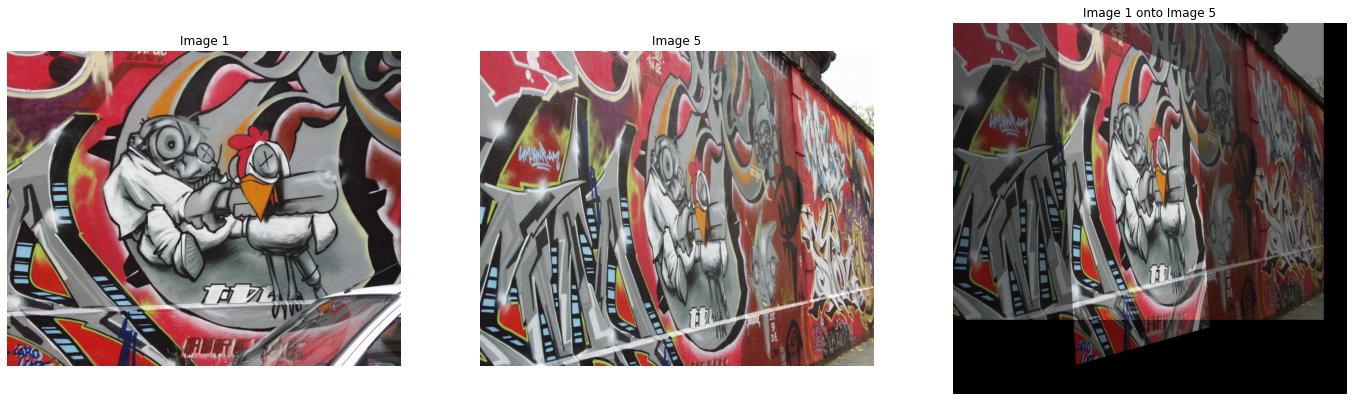

In [238]:
# ======================== part (b) - Computing the Homography with RANSAC =========================
# ------------- finding the Homography and comparing with the homography given in the dataset ------
customH1to4 = RANSACHomography(matches1to4, keys1, keys4, N=800, t=10, d=0.2) # *specifically tuned 
customH4to5 = RANSACHomography(matches4to5, keys4, keys5, N=200, t=3, d=0.5) 

customH1to5 = customH4to5 @ customH1to4  
customH1to5 /= customH1to5[2][2] # setting h33 element to be 1 
H1to5 = comparingAndVisualizingH(customH1to5, "graf/H1to5p")

I = np.identity(3) 
im1onto5 = cv.warpPerspective(img1, H1to5, (850, 800))
im5onto5 = cv.warpPerspective(img5,     I, (850, 800))  

# ------------------------------------- visualizing the results ------------------------------------ 
fig, ax = plt.subplots(1, 3, figsize = (24, 8))  
ax[0].imshow(img1); ax[0].axis('off'); ax[0].set_title("Image 1")  
ax[1].imshow(img5); ax[1].axis('off'); ax[1].set_title("Image 5")
im = cv.addWeighted(im1onto5, 0.5, im5onto5, 0.5, 0) 
ax[2].imshow(im); ax[2].axis('off'); ax[2].set_title("Image 1 onto Image 5") 

<font size="2"> 

* The first matrix (first column) shown above is the homography determined by the customized `RANSACHomography` function, and the second matrix is the pre-determined homography given in the `"H1to5p"` text file. 
* We can clearly observe that both the matrices are almost equal. 